In [4]:
# --- IMPORTS ---------------------------------------------------------------
import numpy as np # fast math + arrays
import pandas as pd # read CSVs, data tables
import scipy.stats as st # probability models + .fit()
import matplotlib.pyplot as plt # plotting
from statsmodels.distributions.empirical_distribution import ECDF
# ECDF: nonparametric cumulative curve
# --- OPTIONAL PLOT STYLE (makes plots cleaner; OK to skip) -----------------
plt.rcParams.update({
"axes.spines.top": False, # cleaner axes
"axes.spines.right": False,
"axes.grid": True, # light grid helps read values
"grid.alpha": 0.25,
})

In [5]:
def plot_ecdf(data, ax=None, **kw):
    """"
    Make an ECDF step plot. 
    WHY: shows all data points; no bins; great for comparing to model CDFs.
    """
    ec = ECDF(data) # compute ECDF object (x,y steps)
    ax = ax or plt.gca() # use passed axes OR current axes
    ax.step(ec.x, ec.y, where="post", **kw)
    ax.set_xlabel("Wait (min)")
    ax.set_ylabel("F_hat(x)") # F-hat = empirical CDF
    return ax

def aic(logL, k):
    """
    Compute Akaike Information Criterion.
    AIC = 2*k - 2*logL
    logL = maximized log-likelihood; k = # free parameters in model.
    Lower AIC -> better tradeoff fit vs complexity (same dataset only!).
    """
    return 2*k - 2*logL

def mean_from_params(dist_name, params):
    """
    Convert SciPy .fit() parameters -> model mean (in minutes).
    SciPy returns (shape[s], loc, scale) in this order for most continuous dists.
    OTE: ’loc’ shifts the distribution; ’scale’ stretches it.
    """
    if dist_name == "gamma":
        a, loc, scale = params # a = shape (k)
        return loc + a*scale # Gamma mean = loc + k*theta
    elif dist_name == "weibull_min":
        c, loc, scale = params # c = shape
        #Weibull mean uses the gamma function:
        return loc + scale*st.gamma(1 + 1/c)
    elif dist_name == "lognorm":
        s, loc, scale = params # s = sigma (log-scale SD); scale = exp(mu)
        # mean = loc + scale * exp( sigma^2 / 2 )
        return loc + scale * np.exp(s**2 / 2)
    else:
        return np.nan # unknown model

In [6]:
df = pd.read_csv("/Users/connor/RISE/lab-6-mbta/Data/mbta_wait_times.csv") 

pre = df.loc[df.period=="PRE", "wait_min"].to_numpy()
post = df.loc[df.period=="POST", "wait_min"].to_numpy()

print(f"PRE n={pre.size}, mean={pre.mean():.2f} min")
print(f"POST n={post.size}, mean={post.mean():.2f} min")

PRE n=600, mean=3.85 min
POST n=650, mean=4.84 min


Q1.1
600 waits were recorded before construction, and 650 waits were recorded after construction.
Q1.2
The raw sample means were 3.85 minutes before construction, and 4.84 minutes after construction.

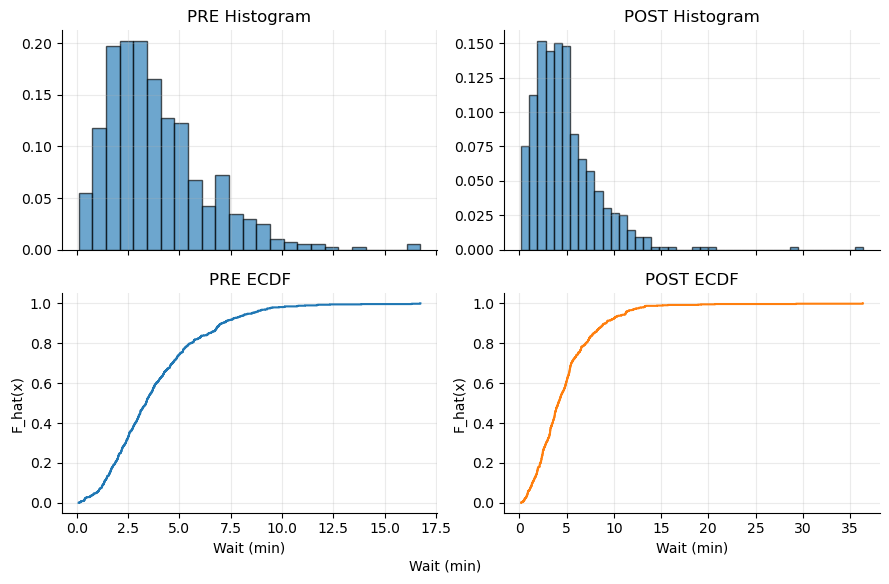

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(9,6), sharex='col')

axs[0,0].hist(pre, bins="auto", density=True, alpha=.65, edgecolor="k")
axs[0,0].set_title("PRE Histogram")
axs[0,1].hist(post, bins="auto", density=True, alpha=.65, edgecolor="k")
axs[0,1].set_title("POST Histogram")


plot_ecdf(pre, ax=axs[1,0], color="C0"); axs[1,0].set_title("PRE ECDF")
plot_ecdf(post, ax=axs[1,1], color="C1"); axs[1,1].set_title("POST ECDF")
fig.text(0.5,0.04,"Wait (min)", ha="center")
fig.tight_layout(rect=[0,0.04,1,1])
plt.show()

In [8]:
PREQ1= np.percentile(pre, 25)
PREQ3= np.percentile(pre, 75)
PREIQR = PREQ3- PREQ1
POSTQ1 =  np.percentile(post, 25)
POSTQ3= np.percentile(post, 75)
POSTIQR = POSTQ3- POSTQ1

PREMAX = 1.5 * PREIQR + PREQ3
PREMIN = PREQ1 - 1.5 * PREIQR 
POSTMAX = 1.5 * POSTIQR + POSTQ3
POSTMIN =POSTQ1 - 1.5 * POSTQ3
PREOutliers = []
for i in range(len(pre)):
    if pre[i] < PREMIN or pre[i] > PREMAX:
        PREOutliers.append(pre[i])
POSTOutliers = []
for i in range(len(post)):
    if post[i] < POSTMIN or post[i] > POSTMAX:
        POSTOutliers.append(post[i])

print(f'PRE Outliers: {PREOutliers}')   
print(f'POST Outliers: {POSTOutliers}')  

PRE Outliers: [np.float64(10.140301361924095), np.float64(12.329866645380712), np.float64(10.103327683786627), np.float64(9.450312777673624), np.float64(9.53380559359136), np.float64(10.779048035513943), np.float64(10.729393331843577), np.float64(11.696088188412755), np.float64(16.747253791076403), np.float64(13.875048039255976), np.float64(9.853289622499425), np.float64(11.739244918496466), np.float64(11.120463173855216), np.float64(9.422282193191313), np.float64(16.31647512129235)]
POST Outliers: [np.float64(13.371061233084175), np.float64(18.90672242169352), np.float64(13.287068768093212), np.float64(19.247471907444726), np.float64(20.70682148802069), np.float64(11.92570392589819), np.float64(12.392507216416744), np.float64(13.232650072889092), np.float64(12.86828829909019), np.float64(12.326314094483868), np.float64(13.151101395124812), np.float64(15.171682174238727), np.float64(29.27458640814392), np.float64(12.65177186074435), np.float64(12.667229050276362), np.float64(14.5597911

Q2.1
The distribution of POST samples is more spread out, having a range of approximately 15 minutes while the distribution of the samples of PRE had a range of around 12.5 minutes. POST is more right skewed, as it has more values spread more to the right than PRE.
Q2.2
POST seems to have more outliers than PRE, as they are a main cause for the right-skewedness. The periods past 15 minutes in PRE and past 17.5 minutes in POST show outliers. 

In [9]:
candidates = {
"gamma": st.gamma,
"weibull_min": st.weibull_min, 
"lognorm": st.lognorm
}
print("Candidate models:", list(candidates))

Candidate models: ['gamma', 'weibull_min', 'lognorm']


Q3.1
We picked Gamme because it can model positive right-skewed data
We picked weibull because it can model using an exponential function to see if it is roughly normal
We picked lognorm because as it takes the logarithms to see if the distribution is roughly normal
Q3.2
You do not want to use a normal distrubtion because it cannot apply to raw data that is not Normally distributed. The central limit theorem does not apply as it is only for sampling distributions, as it takes the means and so the distribution of the means will be approximately Normal, not the data itself.

In [10]:
def fit_models(data, models):
    """
    Fit each SciPy distribution in 'models' to 1-D numpy array 'data'.
    Returns a DataFrame (rows = models, columns = params/logL/k/AIC) sorted by AIC.
    """
    out = {}
    for name, dist in models.items():
        params = dist.fit(data) # MLE: find params that max log-likelihood
        logL = dist.logpdf(data, *params).sum() # total log-likelihood at those params
        k = len(params) # number of fitted parameters
        out[name] = dict(params=params, logL=logL, k=k, AIC=aic(logL,k))
    return pd.DataFrame(out).T.sort_values("AIC") # lower AIC = better
# --- FIT PRE & POST --------------------------------------------------------
fit_pre = fit_models(pre, candidates)
fit_post = fit_models(post, candidates)
print("PRE fits:"); display(fit_pre)
print("POST fits:"); display(fit_post)  

PRE fits:


,params,logL,k,AIC
gamma,"(2.8330720359523776, -0.17588555964314997, 1.4...",-1297.451464,3,2600.902927
lognorm,"(0.45358379824501616, -1.2934360536889966, 4.6...",-1298.316753,3,2602.633505
weibull_min,"(1.4548509669295906, 0.5989530214768142, 3.650...",-inf,3,inf


POST fits:


,params,logL,k,AIC
lognorm,"(0.5360203743986013, -1.0685227608888868, 5.12...",-1578.630755,3,3163.261511
gamma,"(2.102145720176475, 0.08445217003943417, 2.262...",-1578.8265,3,3163.653
weibull_min,"(1.1796449365987804, 0.1889757828003762, 3.582...",-1653.884507,3,3313.769013


In [11]:
fit_pre["dAIC"] = fit_pre["AIC"] - fit_pre["AIC"].min()
fit_post["dAIC"] = fit_post["AIC"] - fit_post["AIC"].min()

print("PRE with ΔAIC:")
display(fit_pre)

print("POST with ΔAIC:")
display(fit_post)

def classify_dAIC(fit_df):
    low = set(fit_df[fit_df["dAIC"] < 2].index)
    mid = set(fit_df[(fit_df["dAIC"] >= 4) & (fit_df["dAIC"] <= 7)].index)
    high = set(fit_df[fit_df["dAIC"] > 10].index)
    return low, mid, high

low_pre, mid_pre, high_pre = classify_dAIC(fit_pre)
low_post, mid_post, high_post = classify_dAIC(fit_post)

print(f"PRE period:")
print(f"ΔAIC < 2 : {low_pre}")
print(f"4 ≤ ΔAIC ≤ 7 : {mid_pre}")
print(f"ΔAIC > 10 : {high_pre}\n")

print(f"POST period:")
print(f"ΔAIC < 2 : {low_post}")
print(f"4 ≤ ΔAIC ≤ 7 : {mid_post}")
print(f"ΔAIC > 10 : {high_post}")

PRE with ΔAIC:


,params,logL,k,AIC,dAIC
gamma,"(2.8330720359523776, -0.17588555964314997, 1.4...",-1297.451464,3,2600.902927,0.0
lognorm,"(0.45358379824501616, -1.2934360536889966, 4.6...",-1298.316753,3,2602.633505,1.730578
weibull_min,"(1.4548509669295906, 0.5989530214768142, 3.650...",-inf,3,inf,inf


POST with ΔAIC:


,params,logL,k,AIC,dAIC
lognorm,"(0.5360203743986013, -1.0685227608888868, 5.12...",-1578.630755,3,3163.261511,0.0
gamma,"(2.102145720176475, 0.08445217003943417, 2.262...",-1578.8265,3,3163.653,0.391489
weibull_min,"(1.1796449365987804, 0.1889757828003762, 3.582...",-1653.884507,3,3313.769013,150.507502


PRE period:
ΔAIC < 2 : {'gamma', 'lognorm'}
4 ≤ ΔAIC ≤ 7 : set()
ΔAIC > 10 : {'weibull_min'}

POST period:
ΔAIC < 2 : {'gamma', 'lognorm'}
4 ≤ ΔAIC ≤ 7 : set()
ΔAIC > 10 : {'weibull_min'}


Q4.1
1) The PRE row with the lowest AIC value is gamma, with a value of 2600.902927.
2) The POST row with the lowest AIC value is lognorm, with a value of 3163.261511
3) PRE best model: gamma (AIC = 2600.902927), POST best model: lognorm (AIC = 3163.261511).


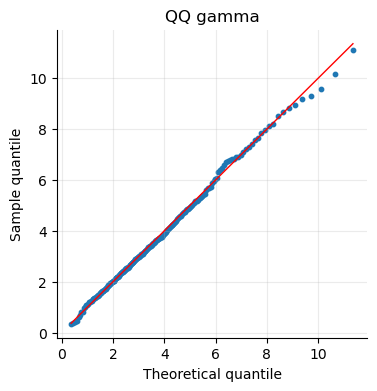

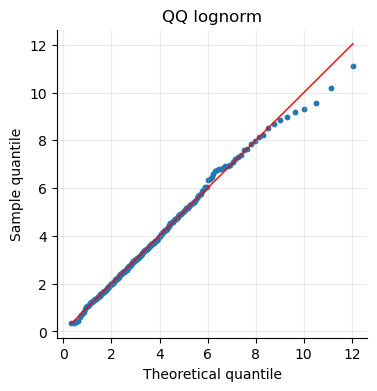

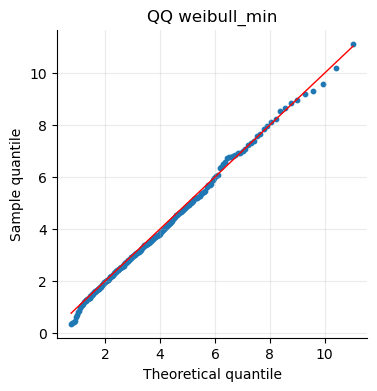

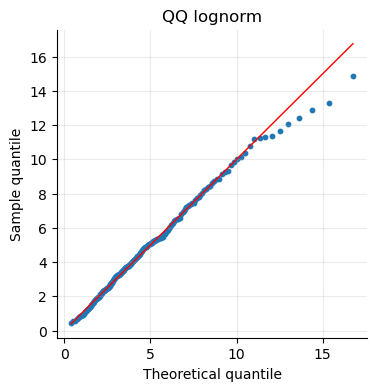

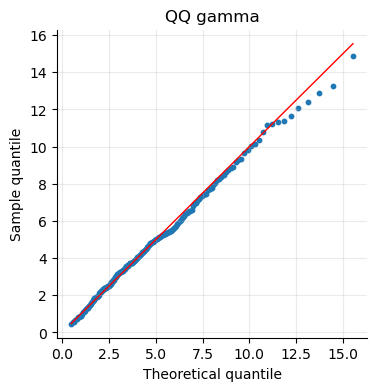

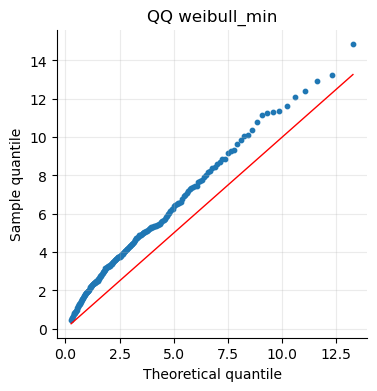

In [12]:
def qq_compare(data, fit_tbl, models, probs=np.linspace(.01,.99,200)):
    """
    ake QQ plots for each fitted model in fit_tbl.
    'probs' are the quantile levels (0-1) we compare.
    """ 
    qs = np.quantile(data, probs) # sample quantiles from data
    for name in fit_tbl.index: # models in AIC order
        dist = models[name]
        params = fit_tbl.loc[name,"params"]
        qt = dist.ppf(probs, *params) # theoretical quantiles from model
        plt.figure(figsize=(4,4))
        plt.scatter(qt, qs, s=10)
        plt.plot(qt, qt, 'r', lw=1) # 45 reference line
        plt.title(f"QQ {name}")
        plt.xlabel("Theoretical quantile")
        plt.ylabel("Sample quantile")
        plt.show()

# --- MAKE QQ PLOTS ---------------------------------------------------------
qq_compare(pre, fit_pre, candidates)
qq_compare(post, fit_post, candidates)

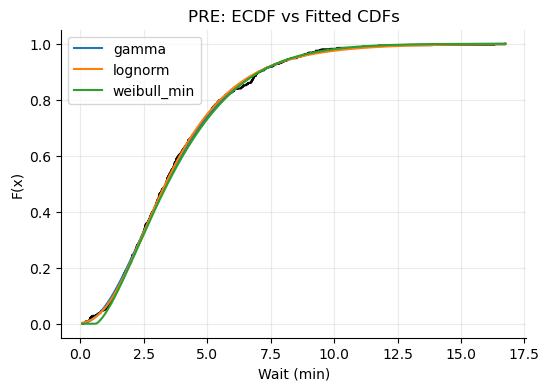

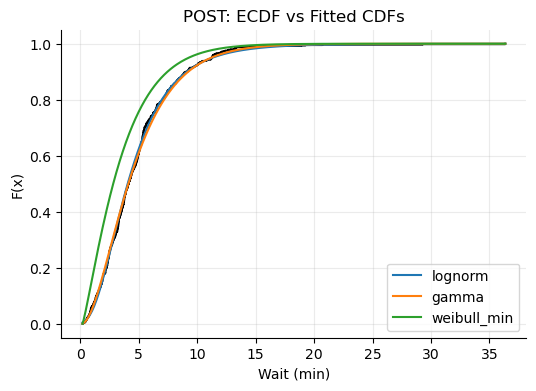

In [13]:
def cdf_overlay(data, fit_tbl, models, title):
    """
    ECDF (black steps) + each fitted model’s CDF (smooth lines).
    """
    plt.figure(figsize=(6,4))
    plot_ecdf(data, color="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.cdf(xx, *pars), label=name)
    plt.legend(); plt.title(title)
    plt.xlabel("Wait (min)"); plt.ylabel("F(x)")
# --- MAKE CDF OVERLAYS -----------------------------------------------------
cdf_overlay(pre, fit_pre, candidates, title="PRE: ECDF vs Fitted CDFs")
cdf_overlay(post, fit_post, candidates, title="POST: ECDF vs Fitted CDFs")

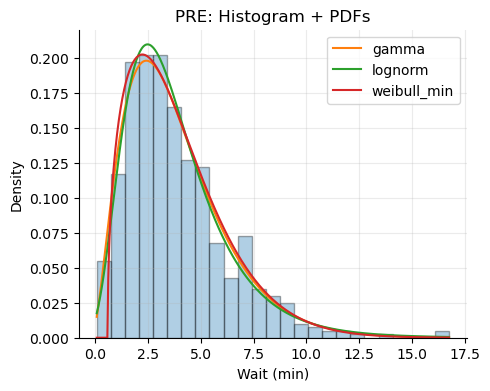

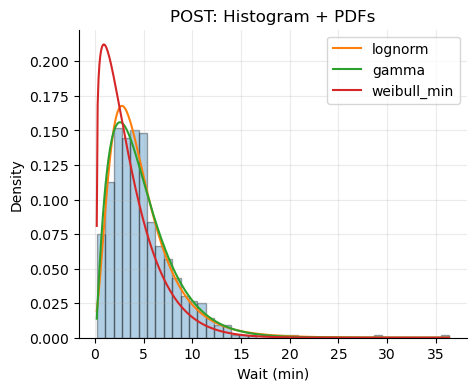

In [14]:
def pdf_overlay(data, fit_tbl, models, title):
    """
    Histogram (density=True) + PDFs from each fitted model.
    """ 
    plt.figure(figsize=(5,4))
    plt.hist(data, bins="auto", density=True, alpha=.35, edgecolor="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.pdf(xx, *pars), label=name)
    plt.legend(); plt.title(title)
    plt.xlabel("Wait (min)"); plt.ylabel("Density")
# --- MAKE PDF OVERLAYS -----------------------------------------------------
pdf_overlay(pre, fit_pre, candidates, "PRE: Histogram + PDFs")
pdf_overlay(post, fit_post, candidates, "POST: Histogram + PDFs")

Q5.1
The models struggle more in the POST period, especially in the upper tail where the fitted curves underestimate the frequency of long waits. This suggests that POST wait times have more extreme values or variability that the models fail to fully capture.

Q5.2
Yes, outliers in the POST period visibly pull the model curves, especially stretching the upper tail of the PDFs and creating gaps between the ECDF and fitted CDFs. This indicates that rare, very long waits significantly affect the model’s ability to fit the data accurately.

In [21]:
best_pre = fit_pre.index[0]
best_post = fit_post.index[0]
# --- GET MEANS FROM FITTED PARAMS ------------------------------------------
mu_pre = mean_from_params(best_pre, fit_pre.loc[best_pre,"params"])
mu_post = mean_from_params(best_post, fit_post.loc[best_post,"params"])
# --- PRACTICAL CHANGE -------------------------------------------------------
delta = mu_post - mu_pre
ratio = mu_post / mu_pre
print(f"Best PRE model: {best_pre} mean{mu_pre:.2f} min")
print(f"Best POST model: {best_post} mean{mu_post:.2f} min")
print(f"Change POST-PRE: {delta:+.2f} min ({ratio:.2f})")

Best PRE model: gamma mean3.85 min
Best POST model: lognorm mean4.84 min
Change POST-PRE: +0.99 min (1.26)


Q6.1
After construction, typical waits are about .99 minutes longer.

Q6.2
Yes, the difference is practically important if it’s enough to cause missed trains or requires riders to adjust their schedules by 1–2 minutes or more. Even small changes can matter during rush hour or when catching connections.

Q6.3
If two models have ∆AIC < 2, it makes the slowdown result more robust, because multiple plausible models agree on the outcome. This suggests that the observed difference isn't sensitive to model choice and likely reflects a real change.